# Weather Predictions

### Import Libraries

In [101]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# and of course the actual regression (machine learning) module
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from statsmodels.stats.stattools import durbin_watson

### Import Data

I found this dataset on kaggle - https://www.kaggle.com/code/esraameslamsayed/eda-for-weather-dataset-for-beginners/log
It does not state any descriptive factors about where this data is from or when it was captured

I took a random sample of 3000 values from the dataset as it was over 8000

In [102]:
raw_data = pd.read_csv('Weather Data.csv')

# Select a random sample of 3000 rows
sample_data = raw_data.sample(n=3000, random_state=42)  # random_state for reproducibility
data = sample_data.copy()

In [103]:
data = data.reset_index(drop=True)
data.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,9/23/2012 1:00,12.80,9.60,81,17,25.00,100.46,Mostly Cloudy
1,3/3/2012 0:00,1.00,-3.20,73,22,25.00,100.12,Cloudy
2,9/29/2012 11:00,12.60,9.80,83,24,24.10,101.19,Cloudy
3,5/11/2012 9:00,11.70,1.60,50,19,48.30,100.63,Mainly Clear
4,1/21/2012 16:00,-11.60,-18.80,55,7,48.30,102.11,Clear


### Preprocessing

### Exploring the descriptive statistics of the variables

In [104]:
data.describe()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,8.58,2.26,67.00,15.30,27.76,101.06
std,11.89,11.11,16.93,8.87,12.67,0.85
min,-21.10,-26.80,18.00,0.00,0.20,97.64
25%,-0.30,-6.10,56.00,9.00,24.10,100.55
50%,9.20,2.70,68.00,15.00,25.00,101.09
75%,18.70,11.70,81.00,20.00,25.00,101.58
max,33.00,23.20,100.00,70.00,48.30,103.65


In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date/Time         3000 non-null   object 
 1   Temp_C            3000 non-null   float64
 2   Dew Point Temp_C  3000 non-null   float64
 3   Rel Hum_%         3000 non-null   int64  
 4   Wind Speed_km/h   3000 non-null   int64  
 5   Visibility_km     3000 non-null   float64
 6   Press_kPa         3000 non-null   float64
 7   Weather           3000 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 187.6+ KB


# Regression Analysis
---

### Visuals | Histograms

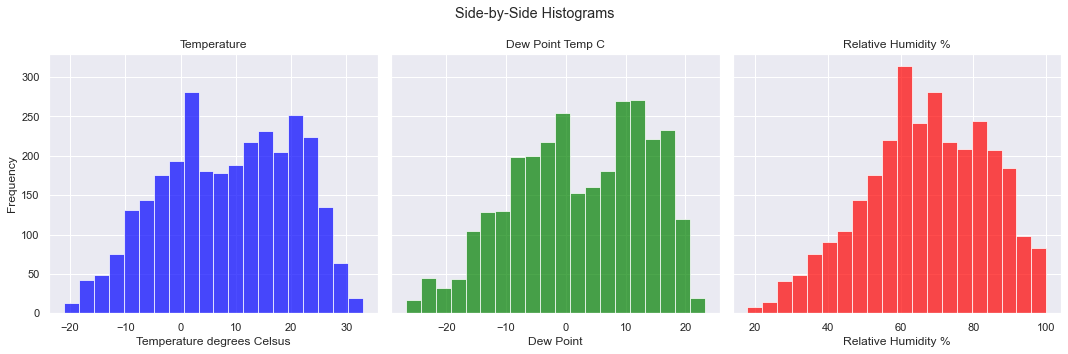

In [106]:
temperature = data['Temp_C']
dew_point = data['Dew Point Temp_C']
rel_humidity = data['Rel Hum_%']

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # sharey=True to use the same y-axis scale

# Plot each histogram on a separate subplot
axes[0].hist(temperature, bins = 20, color='blue', alpha=0.7)
axes[0].set_title('Temperature')
axes[0].set_xlabel('Temperature degrees Celsus')
axes[0].set_ylabel('Frequency')

axes[1].hist(dew_point, bins = 20, color='green', alpha=0.7)
axes[1].set_title('Dew Point Temp C')
axes[1].set_xlabel('Dew Point')

axes[2].hist(rel_humidity, bins = 20, color='red', alpha=0.7)
axes[2].set_title('Relative Humidity %')
axes[2].set_xlabel('Relative Humidity %')



# Add a main title
fig.suptitle('Side-by-Side Histograms')

# Display the plot
plt.tight_layout()
plt.show()

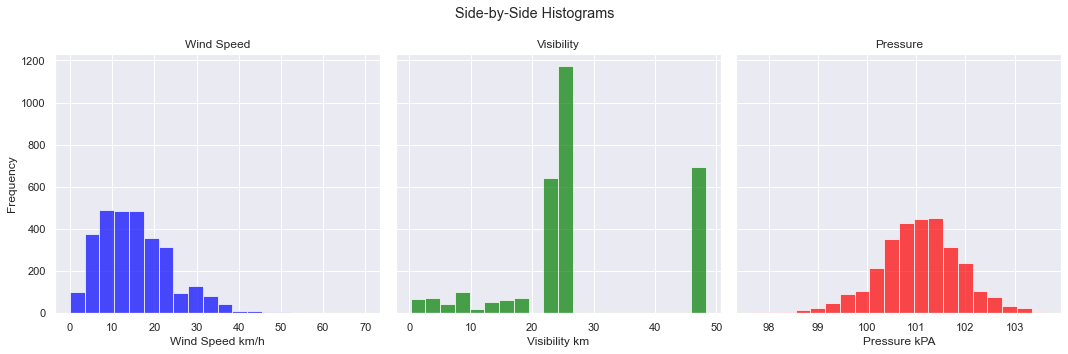

In [107]:
wind_speed = data['Wind Speed_km/h']
visibility = data['Visibility_km']
pressure = data['Press_kPa']

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # sharey=True to use the same y-axis scale

# Plot each histogram on a separate subplot
axes[0].hist(wind_speed, bins=20, color='blue', alpha=0.7)
axes[0].set_title('Wind Speed')
axes[0].set_xlabel('Wind Speed km/h')
axes[0].set_ylabel('Frequency')

axes[1].hist(visibility, bins=20, color='green', alpha=0.7)
axes[1].set_title('Visibility')
axes[1].set_xlabel('Visibility km')

axes[2].hist(pressure, bins=20, color='red', alpha=0.7)
axes[2].set_title('Pressure')
axes[2].set_xlabel('Pressure kPA')

# Add a main title
fig.suptitle('Side-by-Side Histograms')

# Display the plot
plt.tight_layout()
plt.show()

Most variables appear to be normally distributed except for Visibility and Visibility. It is likley to remove Visibility overall and then remove outliers from Wind Speed

## Remove Visibility

In [108]:
normal_data = data.drop(['Visibility_km','Date/Time','Weather'],axis=1)

## Remove Outliers

In [109]:
# There are some outliers present with wind speed and outliers are an issue for OLS as it can inversely skew the predictions
# OLS minimizes the sum of squared errors, so larger errors have a disproportionately high influence. 
# An outlier with a large residual will heavily impact the line of best fit, 
# often skewing the regression coefficients and thus leading to inaccurate estimates
# Here, the outliers are situated around the wind speed (right side of the graph)
# Without diving too deep, we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples

# Let's declare a variable that will be equal to the 99th percentile of the 'Wind Speed_km/h' variable

# DataFrame.quantile(the quantile)
q = normal_data['Wind Speed_km/h'].quantile(0.99)
# Then we can create a new df, with the condition that all wind speeds must be below the 99 percentile of 'Wind Speed_km/h'
data_1 = normal_data[normal_data['Wind Speed_km/h']<q]
# In this way we have essentially removed the top 1% of the data about 'Wind Speed_km/h'
data_1.describe(include='all')

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Press_kPa
count,2967.00,2967.00,2967.00,2967.00,2967.00
mean,8.63,2.29,66.96,14.95,101.08
std,11.93,11.15,16.95,8.25,0.83
min,-21.10,-26.80,18.00,0.00,97.64
25%,-0.30,-6.20,56.00,9.00,100.57
50%,9.30,2.90,68.00,15.00,101.09
75%,18.80,11.70,81.00,20.00,101.59
max,33.00,23.20,100.00,39.00,103.65


<AxesSubplot:xlabel='Wind Speed_km/h', ylabel='Count'>

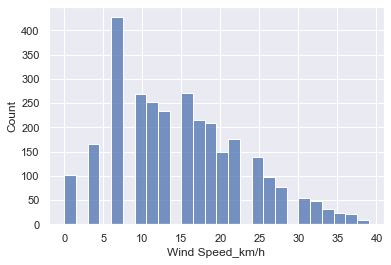

In [110]:
sns.histplot(data_1['Wind Speed_km/h'])

### Reset Index

In [111]:
# When we remove observations, the original indexes are preserved
# If we remove observations with indexes 2 and 3, the indexes will go as: 0,1,4,5,6

# Finally, once we reset the index, a new column will be created containing the old index (just in case)
# We won't be needing it, thus 'drop=True' to completely forget about it
data_cleaned = data_1.reset_index(drop=True)

In [112]:
# Let's see what's left
data_cleaned.describe(include='all')

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Press_kPa
count,2967.00,2967.00,2967.00,2967.00,2967.00
mean,8.63,2.29,66.96,14.95,101.08
std,11.93,11.15,16.95,8.25,0.83
min,-21.10,-26.80,18.00,0.00,97.64
25%,-0.30,-6.20,56.00,9.00,100.57
50%,9.30,2.90,68.00,15.00,101.09
75%,18.80,11.70,81.00,20.00,101.59
max,33.00,23.20,100.00,39.00,103.65


## Check Assumptions

## 1. Linearity with Scatter Plot

### Temperature

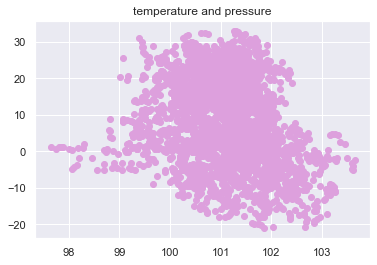

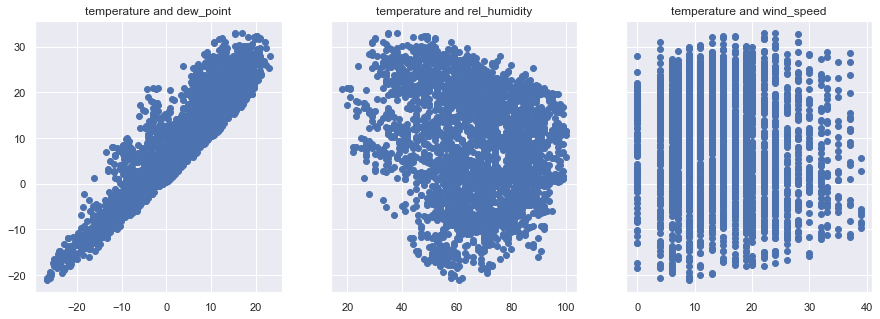

In [113]:
plt.scatter(data_cleaned['Press_kPa'], data_cleaned['Temp_C'], c = '#DDA0DD')
plt.title('temperature and pressure')


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,5)) #sharey -> share 'Price' as y
ax1.scatter(data_cleaned['Dew Point Temp_C'], data_cleaned['Temp_C'])
ax1.set_title('temperature and dew_point')
ax2.scatter(data_cleaned['Rel Hum_%'], data_cleaned['Temp_C'])
ax2.set_title('temperature and rel_humidity')
ax3.scatter(data_cleaned['Wind Speed_km/h'], data_cleaned['Temp_C'])
ax3.set_title('temperature and wind_speed')
plt.show()

Linearity - The Wind Speed scatter plots is non linear but lets run other tests first before it is removed

## Check for Endogeneity

Check variables to make sure their p value <= 0.05 - if it is larger then they need to be removed

In [116]:
y = data_cleaned['Temp_C']
x1 = data_cleaned[['Dew Point Temp_C', 'Press_kPa','Rel Hum_%', 'Wind Speed_km/h']]
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Temp_C   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.485e+05
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:26:54   Log-Likelihood:                -3693.0
No. Observations:                2967   AIC:                             7396.
Df Residuals:                    2962   BIC:                             7426.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               32.5771      2.257     14.433      0.000      28.152      37.003
Dew Point Temp_C     1.0556      0.002    697.114      0.000       1.053       1.059
Press_kPa           -0.0950      0.022     -4.317      0.000      -0.138      -0.052
Rel Hum_%           -0.2495      0.001   -260.520      0.000      -0.251      -0.248
Wind Speed_km/h     -0.0036      0.002     -1.740      0.082      -0.008       0.000
==============================================================================
Omnibus:                     1378.604   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9342.758
Skew:                           2.100   Prob(JB):                         0.00
Kurtosis:                      10.611   Cond. No.                     1.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Wind Speed has a p-value of 0.082 so this must be dropped

In [117]:
data_cleaned = data_cleaned.drop(['Wind Speed_km/h'],axis=1)

## Normality and Homoscedasticity

- Normality - assume the error term is normally distributed
- Homoscedasticity - to have equal variance. The error term should have equal variance, one with the other. If there is heteroscedasticity (huge variance) the you can calculate the naturl log

The histograms appear normally distributed and the scatter plots show Homoscedasity in all variables except for weather with was droped and visibility

## Check for Autocorrelation

- The correlation of a variable with itsself over successive time intervals 
- Use the Durbin Watson test - 0 - 4. 2 indicates no autocorrelation while values below 1 and above 3 cause for alarm use

In [118]:
# Data
y = data_cleaned['Temp_C']
x1 = data_cleaned[['Dew Point Temp_C', 'Rel Hum_%', 'Press_kPa']]

# Add a constant to the independent variables
x = sm.add_constant(x1)

# Fit the OLS regression model
model = sm.OLS(y, x).fit()

# Calculate the Durbin-Watson statistic on the residuals
dw_statistic = durbin_watson(model.resid)
print("Durbin-Watson Statistic:", dw_statistic)

Durbin-Watson Statistic: 2.003220218203236


- The Durbin-Watson statistic ranges from 0 to 4:

    - Results 2: Indicates no autocorrelation.
    - Results 0 to <2: Indicates positive autocorrelation.
    - Results >2 to 4: Indicates negative autocorrelation.

 The Results are 2.00 meaning there is no autocorrelation

## Check for Multicollinearity

We observe multicollinearity when two or more variables have a high correlation.

In [119]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = data_cleaned[['Dew Point Temp_C', 'Rel Hum_%','Press_kPa']]

# create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# include names so it is easier to explore the result
vif["Features"] = variables.columns

vif

,VIF,Features
0,1.07,Dew Point Temp_C
1,16.80,Rel Hum_%
2,16.54,Press_kPa


- VIF = 1: no multicollinearity
- 1 < VIF < 5: perfectly okay
- 5 to 10 < VIF: unaccepta|ble

In [145]:
# Relative Humidity is the highest but after running the model it had a lower R Squared 
# and a high % difference between Training and Testing Data predictions
# This will drive the VIF of other variables down

from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = data_cleaned[['Dew Point Temp_C', 'Rel Hum_%']]

# create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# include names so it is easier to explore the result
vif["Features"] = variables.columns

vif

,VIF,Features
0,1.06,Dew Point Temp_C
1,1.06,Rel Hum_%


In [146]:
# All variables are now below 5

# Drop all irrelevant columns
data_no_multicollinearity = data_cleaned.drop(['Press_kPa'],axis=1)
data_no_multicollinearity

,Temp_C,Dew Point Temp_C,Rel Hum_%
0,12.80,9.60,81
1,1.00,-3.20,73
2,12.60,9.80,83
3,11.70,1.60,50
4,-11.60,-18.80,55
...,...,...,...
2962,-4.60,-10.00,66
2963,-12.70,-20.40,53
2964,12.60,9.70,82
2965,17.30,8.90,58


## Regression Testing

In [147]:
regression_data = data_no_multicollinearity
regression_data

,Temp_C,Dew Point Temp_C,Rel Hum_%
0,12.80,9.60,81
1,1.00,-3.20,73
2,12.60,9.80,83
3,11.70,1.60,50
4,-11.60,-18.80,55
...,...,...,...
2962,-4.60,-10.00,66
2963,-12.70,-20.40,53
2964,12.60,9.70,82
2965,17.30,8.90,58


### Declare the inputs and the targets

In [148]:
# The target(s) (y - dependent variable) is 'Temp_C'
targets = regression_data['Temp_C']

# The inputs are everything BUT the y - dependent variable, so we can simply drop it
inputs = regression_data.drop(['Temp_C'],axis=1)

### Scale & Transform the data

In [35]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(inputs)

StandardScaler()

In [36]:
# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)

### Train Test Split

In [149]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split as mine, use random_state = 365
# first argument refers to the x's & second argument refers to the y's
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=365)

### Create the regression

In [150]:
# Create a linear regression object
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)

LinearRegression()

In [151]:
# Let's check the outputs of the regression
# I'll store them in y_hat as this is the 'theoretical' name of the predictions
y_hat = reg.predict(x_train)

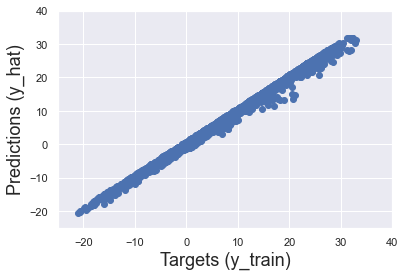

In [152]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.xlim(-25,40)
plt.ylim(-25,40)
plt.show()

### Plot the Residuals

C:\Users\LE732\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals PDF')

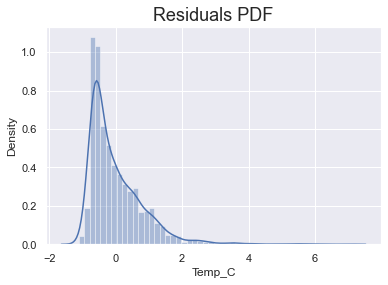

In [153]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_train - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

# In the best case scenario this plot should be normally distributed
# In our case we notice that there are many positive residuals (far away from the mean)

### Find the R Squared

In [154]:
reg.score(x_train,y_train)

0.9950888806733126

### Finding the weights and bias (intercept)

In [155]:
reg.intercept_

22.816965894858455

In [156]:
# Obtain the weights (coefficients) of the regression
reg.coef_

array([ 1.05697594, -0.24827783])

In [157]:
# Create a regression summary where we can compare them with one-another
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
intercept_row = pd.DataFrame([['Intercept', reg.intercept_]], columns=['Features', 'Weights'])
reg_summary = pd.concat([intercept_row, reg_summary], ignore_index=True)
reg_summary

,Features,Weights
0,Intercept,22.82
1,Dew Point Temp_C,1.06
2,Rel Hum_%,-0.25


### Temperature Regression

I will only use 'Dew Point Temp_C' and 'Rel Hum_%' as they have passed all the OLS Tests

In [158]:
x = sm.add_constant(x_train)
results = sm.OLS(y_train,x).fit()
#.fit() applys estimation technique (OLS - ordinary least square) to obtain the fit of the model

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Temp_C   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.401e+05
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:31:58   Log-Likelihood:                -2940.0
No. Observations:                2373   AIC:                             5886.
Df Residuals:                    2370   BIC:                             5903.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               22.8170      0.071    322.730      0.000      22.678      22.956
Dew Point Temp_C     1.0570      0.002    679.817      0.000       1.054       1.060
Rel Hum_%           -0.2483      0.001   -240.171      0.000      -0.250      -0.246
==============================================================================
Omnibus:                     1173.912   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9114.498
Skew:                           2.204   Prob(JB):                         0.00
Kurtosis:                      11.529   Cond. No.                         284.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Testing

Once we have trained and fine-tuned our model, we can proceed to testing it. 
Testing is done on a dataset that the algorithm has never seen

In [159]:
# Our test inputs are 'x_test', while the outputs: 'y_test' 
# We SHOULD NOT TRAIN THE MODEL ON THEM, we just feed them and find the predictions
# If the predictions are far off, we will know that our model overfitted
y_hat_test = reg.predict(x_test)

In [160]:
y = data_no_multicollinearity['Temp_C']
x1 = data_no_multicollinearity[['Dew Point Temp_C', 'Rel Hum_%']]

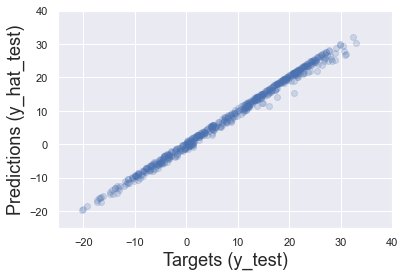

In [161]:
# Create a scatter plot with the test targets and the test predictions
# You can include the argument 'alpha' which will introduce opacity to the graph
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(-25,40)
plt.ylim(-25,40)
plt.show()

Our model appears to be great at predicting lower to average temperatures but gets a smidge dispersed around higher temperatures

In [162]:
# Finally, let's manually check these predictions
df_pf = pd.DataFrame(y_hat_test, columns=['Prediction'])
df_pf.head()

,Prediction
0,12.55
1,22.28
2,-0.31
3,11.79
4,11.73


In [163]:
# The old indexes are preserved (recall earlier in that code we made a note on that)
# Therefore, to get a proper result, we must reset the index and drop the old indexing
y_test = y_test.reset_index(drop=True)

# Check the result
y_test.head()

0   12.00
1   21.70
2   -0.60
3   12.00
4   11.00
Name: Temp_C, dtype: float64

In [164]:
# Let's overwrite the 'Target' column with the appropriate values
df_pf['Target'] = y_test
df_pf

,Prediction,Target
0,12.55,12.00
1,22.28,21.70
2,-0.31,-0.60
3,11.79,12.00
4,11.73,11.00
5,-6.95,-7.50
6,18.84,18.20
7,-7.16,-6.80
8,-1.34,-2.00
9,-10.99,-11.90


In [165]:
# Additionally, we can calculate the difference between the targets and the predictions
# Note that this is actually the residual (we already plotted the residuals)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

# Since OLS is basically an algorithm which minimizes the total sum of squared errors (residuals),
# this comparison makes a lot of sense

In [166]:
# Finally, it makes sense to see how far off we are from the result percentage-wise
# Here, we take the absolute difference in %, so we can easily order the data frame

pd.options.display.max_rows = 999
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,12.55,12.00,-0.55,4.59
1,22.28,21.70,-0.58,2.65
2,-0.31,-0.60,-0.29,48.83
3,11.79,12.00,0.21,1.73
4,11.73,11.00,-0.73,6.59
5,-6.95,-7.50,-0.55,7.32
6,18.84,18.20,-0.64,3.51
7,-7.16,-6.80,0.36,5.23
8,-1.34,-2.00,-0.66,32.79
9,-10.99,-11.90,-0.91,7.65


In [167]:
# Exploring the descriptives here gives us additional insights
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,594.00,594.00,594.00,594.00
mean,8.32,8.39,0.07,inf
std,11.88,11.97,0.87,NaN
min,-19.52,-20.30,-0.97,0.00
25%,-1.32,-0.88,-0.57,2.44
50%,9.09,9.25,-0.18,4.97
75%,18.92,18.77,0.50,12.91
max,32.11,32.90,5.41,inf


### Sort Data to view manually

In [168]:
# Sometimes it is useful to check these outputs manually
# To see all rows, we use the relevant pandas syntax
pd.options.display.max_rows = 999
# Moreover, to make the dataset clear, we can display the result with only 2 digits after the dot 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Finally, we sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
526,10.00,10.00,0.00,0.00
195,18.91,18.90,-0.01,0.03
70,-11.80,-11.80,-0.00,0.03
329,11.19,11.20,0.01,0.05
551,24.18,24.20,0.02,0.08
593,9.51,9.50,-0.01,0.08
241,15.39,15.40,0.01,0.10
256,21.12,21.10,-0.02,0.12
547,14.18,14.20,0.02,0.13
156,14.08,14.10,0.02,0.14


## Categorical Clusters
---

In [215]:
#unique values of weather & count
data['Weather'].value_counts()

Mostly Cloudy                     721
Mainly Clear                      714
Cloudy                            596
Clear                             441
Snow                              143
Rain                               86
Rain Showers                       65
Fog                                51
Rain,Fog                           44
Drizzle,Fog                        29
Snow Showers                       20
Drizzle                            17
Snow,Fog                            8
Snow,Blowing Snow                   7
Rain,Snow                           7
Freezing Rain                       6
Freezing Drizzle,Snow               5
Thunderstorms,Rain Showers          4
Drizzle,Snow,Fog                    4
Snow,Haze                           3
Freezing Drizzle                    3
Haze                                3
Freezing Drizzle,Haze               2
Freezing Drizzle,Fog                2
Rain,Snow,Ice Pellets               2
Moderate Snow                       2
Freezing Rai

## Visuals

Text(0.5, 0, 'Weather Conditions')

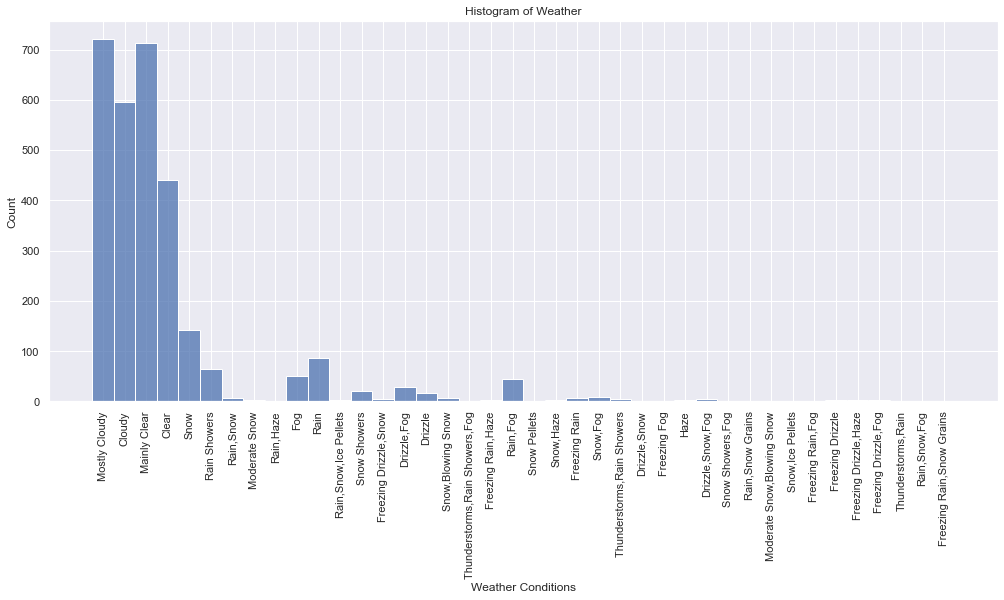

In [138]:
weather = data['Weather']

plt.figure(figsize=(17, 7))
sns.histplot(weather) 
#plt.hist(weather) 
plt.xticks(rotation=90)
plt.title('Histogram of Weather')
plt.xlabel('Weather Conditions')

In [139]:
data.groupby('Weather').mean()

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa
Weather,,,,,,
Clear,6.682993,-0.253515,63.746032,10.122449,29.791610,101.629048
Cloudy,7.970470,2.556879,70.109060,16.011745,26.805705,100.935336
Drizzle,7.570588,5.511765,87.058824,16.294118,17.464706,100.245294
"Drizzle,Fog",9.148276,8.086207,93.103448,12.310345,5.448276,100.761724
"Drizzle,Snow",0.900000,0.200000,95.000000,19.000000,11.300000,100.630000
"Drizzle,Snow,Fog",0.775000,0.025000,94.750000,20.000000,6.825000,98.890000
Fog,4.476471,3.260784,91.784314,8.372549,6.139216,101.096863
Freezing Drizzle,-4.866667,-6.800000,86.333333,18.666667,9.133333,100.560000
"Freezing Drizzle,Fog",-1.100000,-2.550000,90.000000,26.000000,6.000000,99.645000


### Select the Features

In [66]:
x = data.iloc[:,1:7]
x

,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa
0,-1.8,-3.9,86,4,8.0,101.24
1,-1.8,-3.7,87,4,8.0,101.24
2,-1.8,-3.4,89,7,4.0,101.26
3,-1.5,-3.2,88,6,4.0,101.27
4,-1.5,-3.3,88,7,4.8,101.23
...,...,...,...,...,...,...
8779,0.1,-2.7,81,30,9.7,100.13
8780,0.2,-2.4,83,24,9.7,100.03
8781,-0.5,-1.5,93,28,4.8,99.95
8782,-0.2,-1.8,89,28,9.7,99.91


### Clustering

In [90]:
kmeans = KMeans(4)

In [91]:
# Fit the input data, i.e. cluster the data in X in K clusters
kmeans.fit(x)

KMeans(n_clusters=4)

### Clustering the Results

In [92]:
# Create a variable which will contain the predicted clusters for each observation
identified_clusters = kmeans.fit_predict(x)
# Check the result
identified_clusters

array([1, 1, 1, ..., 1, 1, 1])

In [98]:
# Create a copy of the data
data_with_clusters = data.copy()
# Create a new Series, containing the identified cluster for each observation
data_with_clusters['Cluster'] = identified_clusters
# Check the result
data_with_clusters

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather,Cluster
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog,1
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog,1
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog",1
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog",1
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog,1
...,...,...,...,...,...,...,...,...,...
8779,12/31/2012 19:00,0.1,-2.7,81,30,9.7,100.13,Snow,1
8780,12/31/2012 20:00,0.2,-2.4,83,24,9.7,100.03,Snow,1
8781,12/31/2012 21:00,-0.5,-1.5,93,28,4.8,99.95,Snow,1
8782,12/31/2012 22:00,-0.2,-1.8,89,28,9.7,99.91,Snow,1


In [71]:
data_with_clusters['Cluster'].unique()

array([0, 2, 4, 1, 3])

### Elbow with non Standardized Variables

In [86]:
# Create an empty list
wcss=[]

# Create all possible cluster solutions with a loop
for i in range(1,9):
    # Cluster solution with i clusters
    kmeans = KMeans(i)
    # Fit the data
    kmeans.fit(x)
    # Find WCSS for the current iteration
    wcss_iter = kmeans.inertia_
    # Append the value to the WCSS list
    #list.append(x)
    wcss.append(wcss_iter)
wcss

[6822937.053817487,
 4579099.5477408,
 3434103.4423911427,
 2787451.5204349062,
 2475747.415064943,
 2238985.848050874,
 2060169.6229277765,
 1888849.80526073]

#### Plot Elbow

Text(0, 0.5, 'Within-cluster Sum of Squares')

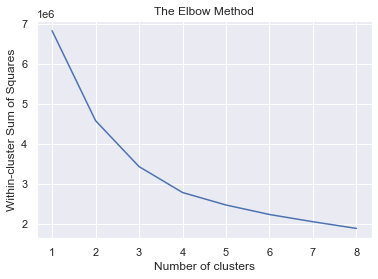

In [81]:
# Create a variable containing the numbers from 1 to 6, so we can use it as X axis of the future plot
number_clusters = range(1,9)
# Plot the number of clusters vs WCSS
plt.plot(number_clusters,wcss)
# Name your graph
plt.title('The Elbow Method')
# Name the x-axis
plt.xlabel('Number of clusters')
# Name the y-axis
plt.ylabel('Within-cluster Sum of Squares')

### Standardize the Variables

In [72]:
# Import a library which can do that easily
from sklearn import preprocessing
# Scale the inputs
# preprocessing.scale scales each variable (column in x) with respect to itself
# The new result is an array
x_scaled = preprocessing.scale(x)
x_scaled

array([[-0.90681502, -0.59318371,  1.09755264, -1.25980838, -1.55795388,
         0.22320647],
       [-0.90681502, -0.5748055 ,  1.15666157, -1.25980838, -1.55795388,
         0.22320647],
       [-0.90681502, -0.54723818,  1.27487942, -0.91451252, -1.87486163,
         0.24690437],
       ...,
       [-0.79558239, -0.37264519,  1.51131513,  1.5025585 , -1.81148008,
        -1.30530797],
       [-0.76991332, -0.40021251,  1.27487942,  1.5025585 , -1.42326809,
        -1.35270376],
       [-0.7528006 , -0.42777982,  1.09755264,  1.73275574, -1.29650499,
        -1.37640166]])

### Elbow Method

In [87]:
# Createa an empty list
wcss =[]

# Create all possible cluster solutions with a loop
# We have chosen to get solutions from 1 to 9 clusters; you can ammend that if you wish
for i in range(1,9):
    # Clsuter solution with i clusters
    kmeans = KMeans(i)
    # Fit the STANDARDIZED data
    kmeans.fit(x_scaled)
    # Append the WCSS for the iteration
    wcss.append(kmeans.inertia_)
    
# Check the result
wcss

[52704.0,
 39167.99887386893,
 31382.25727217609,
 26067.531149894297,
 23581.094567066284,
 21892.11498449014,
 20493.927140333228,
 19245.562021858408]

#### Plot Elbow

Text(0, 0.5, 'WCSS')

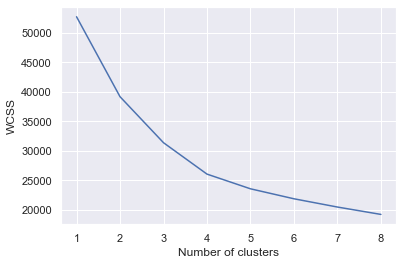

In [88]:
# Plot the number of clusters vs WCSS
plt.plot(range(1,9),wcss)
# Name your axes
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [107]:
# Fiddle with K (the number of clusters)
kmeans_new = KMeans(4)
# Fit the data
kmeans_new.fit(x_scaled)
# Create a new data frame with the predicted clusters
clusters_new = data.copy()
clusters_new['cluster_pred'] = kmeans_new.fit_predict(x_scaled)
# includes the original values & predictions based on standardized data
# Convert entire data frame as string and print
print(clusters_new[['Temp_C', 'Dew Point Temp_C', 'Rel Hum_%','Visibility_km', 'Press_kPa', 'Weather',
       'cluster_pred']].to_string())

      Temp_C  Dew Point Temp_C  Rel Hum_%  Visibility_km  Press_kPa                                  Weather  cluster_pred
0       -1.8              -3.9         86            8.0     101.24                                      Fog             2
1       -1.8              -3.7         87            8.0     101.24                                      Fog             2
2       -1.8              -3.4         89            4.0     101.26                     Freezing Drizzle,Fog             2
3       -1.5              -3.2         88            4.0     101.27                     Freezing Drizzle,Fog             2
4       -1.5              -3.3         88            4.8     101.23                                      Fog             2
5       -1.4              -3.3         87            6.4     101.27                                      Fog             2
6       -1.5              -3.1         89            6.4     101.29                                      Fog             2
7       -1.4    

In [101]:
clusters_new.columns

Index(['Date/Time', 'Temp_C', 'Dew Point Temp_C', 'Rel Hum_%',
       'Wind Speed_km/h', 'Visibility_km', 'Press_kPa', 'Weather',
       'cluster_pred'],
      dtype='object')